In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
# plt.style.use('seaborn-paper')
import seaborn as sns
# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.facecolor'] = 'white'  # 设置全局图形背景颜色为白色
plt.rcParams['axes.facecolor'] = 'white'    # 设置全局绘图区背景颜色为白色
from matplotlib.lines import Line2D

In [2]:
datajh=pd.read_csv("groupedjhS.csv")
datacm=pd.read_csv("groupedcmS.csv")

In [3]:
VOCs = ['Methyl Mercaptan', '1,3-Butadiene', 'Butene', 'Acetone/Butane', 'n-Propanol',
        'Dimethyl Sulfide/Ethyl Mercaptan', 'Chloroethane', 'Isoprene', 'Pentene', 'Pentane/Isopentane',
        'Dimethylformamide', 'Ethyl Formate', 'Carbon Disulfide/Propyl Mercaptan', 'Benzene', 'Cyclohexene',
        'Hexene/Methylcyclopentane', 'n-Hexane/Dimethylbutane', 'Ethyl Sulfide/Butyl Mercaptan', 'Toluene', 'Aniline',
        'Dimethyl Disulfide', '1,1-Dichloroethylene', 'Methylcyclohexane', 'n-Heptane', 'Triethylamine',
        'n-Propyl Acetate', 'Diethylene Triamine', 'Styrene', 'Xylene/Ethylbenzene', '1,3-Dichloropropene', 'n-Octane',
        'n-Butyl Acetate', 'Hexyl Mercaptan', 'Xylenol', 'Trichloroethylene', 'Diethylbenzene', 'Methyl Benzoate',
        'Trimethyl Phosphate', 'n-Decanol', 'Dichlorobenzene', 'Diethyl Aniline', 'Undecane', 'Tetrachloroethylene',
        'n-Dodecane', 'Dibromomethane', '1,2,4-Trichlorobenzene', 'n-Tridecane', '1,2-Dibromoethane']
datajh['place'] = 'JH'
datacm['place'] = 'CM'
dataall = pd.concat([datajh, datacm], axis=0)
dataall.columns = ['Time', 'TVOCs', 'Methyl Mercaptan', '1,3-Butadiene', 'Butene', 'Acetone/Butane', 'n-Propanol',
                   'Dimethyl Sulfide/Ethyl Mercaptan', 'Chloroethane', 'Isoprene', 'Pentene', 'Pentane/Isopentane',
                   'Dimethylformamide', 'Ethyl Formate', 'Carbon Disulfide/Propyl Mercaptan', 'Benzene', 'Cyclohexene',
                   'Hexene/Methylcyclopentane', 'n-Hexane/Dimethylbutane', 'Ethyl Sulfide/Butyl Mercaptan', 'Toluene',
                   'Aniline', 'Dimethyl Disulfide', '1,1-Dichloroethylene', 'Methylcyclohexane', 'n-Heptane',
                   'Triethylamine', 'n-Propyl Acetate', 'Diethylene Triamine', 'Styrene', 'Xylene/Ethylbenzene',
                   '1,3-Dichloropropene', 'n-Octane', 'n-Butyl Acetate', 'Hexyl Mercaptan', 'Xylenol',
                   'Trichloroethylene', 'Diethylbenzene', 'Methyl Benzoate', 'Trimethyl Phosphate', 'n-Decanol',
                   'Dichlorobenzene', 'Diethyl Aniline', 'Undecane', 'Tetrachloroethylene', 'n-Dodecane',
                   'Dibromomethane', '1,2,4-Trichlorobenzene', 'n-Tridecane', '1,2-Dibromoethane', '0.25um', '0.28um',
                   '0.30um', '0.35um', '0.40um', '0.45um', '0.50um', '0.58um', '0.65um', '0.70um', '0.80um', '1.00um',
                   '1.30um', '1.60um', '2.00um', '2.50um', '3.00um', '3.50um', '4.00um', '5.00um', '6.50um', '7.50um',
                   '8.50um', '10.00um', '12.50um', '15.00um', '17.50um', '20.00um', '25.00um', '30.00um', '32.00um',
                   'PM10', 'PM2.5', 'PM1', 'SO2', 'NOx', 'NO', 'NO2', 'CO', 'O3', 'NO2.1', 'NegativeOxygenIons',
                   'Radiation', 'Temperature', 'Humidity', 'WindSpeed', 'Hour_Min_Sec', 'Hour_Min', 'Hour', 'Month',
                   'Day', 'Datetime', 'seconds', 'place']


In [4]:
from scipy.stats import norm, expon, gamma, lognorm, beta, kstest, shapiro


def normal_distribution_fit_and_test(grouped_by_hour):
    normality_results = {}
    for hour, group in grouped_by_hour:
        # Fit normal distribution and get parameters
        params = norm.fit(group)
        # Perform Shapiro-Wilk test
        _, p_value = shapiro(group)
        # Check if data is normally distributed based on p-value
        is_normal = True if p_value > 0.05 else False
        normality_results[hour] = (
            params[0], params[1], p_value, is_normal)  # params[0]: mean, params[1]: standard deviation

    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ["Mean", "Standard Deviation", "P-Value", "Is Normal"]
    normality_df.reset_index(inplace=True)
    normality_df.rename(columns={'index': 'Hour'}, inplace=True)

    return normality_df


from scipy.optimize import curve_fit


# 定义与均值 Mean 的关系的函数
def mean_relation(T, Q0, a, v0):
    return Q0 + (a * T ** 2) / 2 + T * v0


# 定义与方差 variance 的关系的函数
def std_dev_relation(T, k, sigma0):
    return ((k ** 2) * (T ** 3)) / 3 + k * (T ** 2) * sigma0 + T * (sigma0 ** 2)


from scipy.stats import zscore
from scipy.stats import t


# 定义去除离群值的函数（使用 Z-score 方法）
def remove_outliers(data):
    z_scores = zscore(data)
    return data[(np.abs(z_scores) < 3)]  # 通常使用 3 作为 Z-score 的阈值

In [5]:
# 定义处理化学物质数据的函数
def process_chemical(data, chemical_name):
    data_grouped = data.groupby(["Hour_Min"]).mean(numeric_only=True).reset_index()
    data_grouped["Concentration"] = data_grouped[chemical_name]
    grouped_by_hour = data_grouped.groupby('Hour')
    normality_df = normal_distribution_fit_and_test(grouped_by_hour[chemical_name])
    normality_df['T'] = data_grouped.groupby('Hour').mean(numeric_only=True)["Temperature"]

    # 提取数据
    T = normality_df['T'].values
    mean_values = normality_df['Mean'].astype("float").values
    std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2

    # 去除离群值
    mean_values_filtered = remove_outliers(mean_values)
    std_dev_values_filtered = remove_outliers(std_dev_values)
    T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
    T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]
    

    # 拟合模型
    params_mean, covariance_mean = curve_fit(mean_relation, T_filtered_mean, mean_values_filtered, method='trf', maxfev=10000)
    params_std_dev, covariance_std_dev = curve_fit(std_dev_relation, T_filtered_std_dev, std_dev_values_filtered, method='trf', maxfev=10000,
    bounds=([0, -np.inf], [np.inf, np.inf]))

    # 计算统计量
    p_values_mean = calculate_p_values(params_mean, covariance_mean, len(T_filtered_mean))
    p_values_std_dev = calculate_p_values(params_std_dev, covariance_std_dev, len(T_filtered_std_dev))
    r_squared_mean = calculate_r_squared(mean_values_filtered, mean_relation, T_filtered_mean, params_mean)
    r_squared_std_dev = calculate_r_squared(std_dev_values_filtered, std_dev_relation, T_filtered_std_dev, params_std_dev)
    
    # 计算占比 %
    total_mean_concentration = data[VOCs].mean().sum()  # 总体均值
    percentage = (np.mean(mean_values_filtered) / total_mean_concentration) * 100  # 占比 %
 

    # 整理结果
    return {
        'Chemical': chemical_name,
        'Average Concentration': np.mean(mean_values_filtered),
        'R2 Mean': r_squared_mean,
        'Concentration Std Dev': np.std(mean_values_filtered),
        'R2 Std Dev': r_squared_std_dev,
        'Percentage (%)': percentage,
        'Q0': params_mean[0],
        'Pvalue Q0': p_values_mean[0],
        'a': params_mean[1],
        'Pvalue a': p_values_mean[1],
        'v0': params_mean[2],
        'Pvalue v0': p_values_mean[2],
        'k': params_std_dev[0],
        'Pvalue k': p_values_std_dev[0],
        'sigma0': params_std_dev[1],
        'Pvalue sigma0': p_values_std_dev[1]
    },params_mean,params_std_dev

# 定义用于计算 P 值和 R² 的辅助函数
def calculate_p_values(params, covariance, n):
    std_errors = np.sqrt(np.diag(covariance))
    t_values = params / std_errors
    dof = max(0, n - len(params))
    p_values = 2 * (1 - t.cdf(np.abs(t_values), dof))
    return p_values

def calculate_r_squared(data, fit_function, T, params):
    residuals = data - fit_function(T, *params)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((data - np.mean(data)) ** 2)
    return 1 - (ss_res / ss_tot)


In [6]:

from scipy.stats import (
    gaussian_kde,
    norm,
    uniform,
    gamma,
    weibull_min,
    pearson3  # 用于对数皮尔逊III型分布
)

def kl_divergence(p, q, x_vals):
    """
    计算两个概率密度之间的KL散度
    """
    return np.sum(p * np.log(p / (q + 1e-10))) * (x_vals[1] - x_vals[0])

def adaptive_penalty_coefficient(sim_var, real_var):
    variance_ratio = sim_var / real_var
    if variance_ratio > 1:
        return np.exp(variance_ratio)
    else:
        # return np.log(variance_ratio+1) / np.log(100)  # 如果模拟方差不超过真实方差，则轻微惩罚
        return 0  

def monte_carlo_density_r_squared(
    T,
    mean_params,
    std_dev_params,
    real_data,
    num_simulations=1000,
    distribution='uniform'  # 新增参数，默认为 'uniform'
):
    """
    基于概率密度的蒙特卡罗模拟方法计算调整后的 R²，考虑自适应的方差惩罚。

    T: 自变量（例如温度）
    mean_params: 拟合的均值函数参数
    std_dev_params: 拟合的方差函数参数
    real_data: 原始观测数据
    num_simulations: 模拟次数
    distribution: 零模型的分布类型，支持 'normal', 'uniform', 'gamma', 'weibull', 'logpearson3'
    """
    # 计算观测数据的概率密度
    density_obs = gaussian_kde(real_data)
    x_vals = np.linspace(np.min(real_data), np.max(real_data), 100)
    p_obs = density_obs(x_vals)
    
    simv=[]
    ov=[]

    # 根据指定的分布类型计算零模型的概率密度
    if distribution == 'normal':
        mean_obs, std_obs = np.mean(real_data), np.std(real_data)
        p_null = norm.pdf(x_vals, loc=mean_obs, scale=std_obs)
    elif distribution == 'uniform':
        a, b = np.min(real_data), np.max(real_data)
        p_null = uniform.pdf(x_vals, loc=a, scale=b - a)
    elif distribution == 'gamma':
        params = gamma.fit(real_data, floc=0)  # 固定 loc=0，避免负值
        shape, loc, scale = params
        p_null = gamma.pdf(x_vals, a=shape, loc=loc, scale=scale)
    elif distribution == 'weibull':
        params = weibull_min.fit(real_data, floc=0)  # 固定 loc=0
        c, loc, scale = params
        p_null = weibull_min.pdf(x_vals, c=c, loc=loc, scale=scale)
    elif distribution == 'logpearson3':
        # 对数据取对数
        positive_data = real_data[real_data > 0]  # 确保数据为正
        log_data = np.log(positive_data)
        # 拟合 Pearson III 型分布
        skew, loc, scale = pearson3.fit(log_data)
        # 计算对数空间的概率密度
        log_x_vals = np.log(x_vals[x_vals > 0])  # x_vals 也要为正
        p_null_log = pearson3.pdf(log_x_vals, skew=skew, loc=loc, scale=scale)
        # 转换回原始空间的概率密度
        p_null = np.zeros_like(x_vals)
        p_null[x_vals > 0] = (1 / x_vals[x_vals > 0]) * p_null_log
    else:
        raise ValueError(f"不支持的分布类型：{distribution}")

    kl_null = kl_divergence(p_obs, p_null, x_vals)

    # 模拟路径的KL散度和自适应惩罚
    kl_total = 0
    penalty_total = 0

    for _ in range(num_simulations):
        # 生成模拟路径
        simulated_path = np.random.normal(
            loc=mean_relation(T, *mean_params),
            scale=np.sqrt(std_dev_relation(T, *std_dev_params)),
            size=len(T)
        )
        
        # 计算模拟路径的概率密度
        density_sim = gaussian_kde(simulated_path)
        p_sim = density_sim(x_vals)
        
        # 计算观测数据与模拟数据的KL散度
        kl_sim = kl_divergence(p_obs, p_sim, x_vals)
        kl_total += kl_sim
        
        # 计算模拟路径的方差，并计算自适应惩罚
        sim_var = np.var(simulated_path)
        real_var = np.var(real_data)
        penalty = adaptive_penalty_coefficient(sim_var, real_var)
        penalty_total += penalty
        simv.append(sim_var)
        ov.append(real_var)

    # 计算平均KL散度和平均自适应惩罚
    kl_avg = kl_total / num_simulations
    mean_penalty = penalty_total / num_simulations

    
    print(np.mean(simv)/np.mean(ov))

    # 计算调整后的 R²，考虑自适应的方差惩罚
    adjusted_r_squared = (1 - (kl_avg / kl_null)) / (1 + mean_penalty)
    print(adjusted_r_squared)
    adjusted_r_squared = np.clip(adjusted_r_squared, 0, 1)  # 限制 R² 在 [0, 1] 之间

    return adjusted_r_squared

# 定义异常值清理函数
def clean_data(df, columns, threshold=3):
    for col in columns:
        df = df[np.abs(zscore(df[col])) < threshold]
    return df.reset_index(drop=True)

def hour_min_to_float(hour_min_str):
    hour, minute = map(int, hour_min_str.split(":"))
    return hour + minute / 60.0

(1425, 100)
(1428, 100)


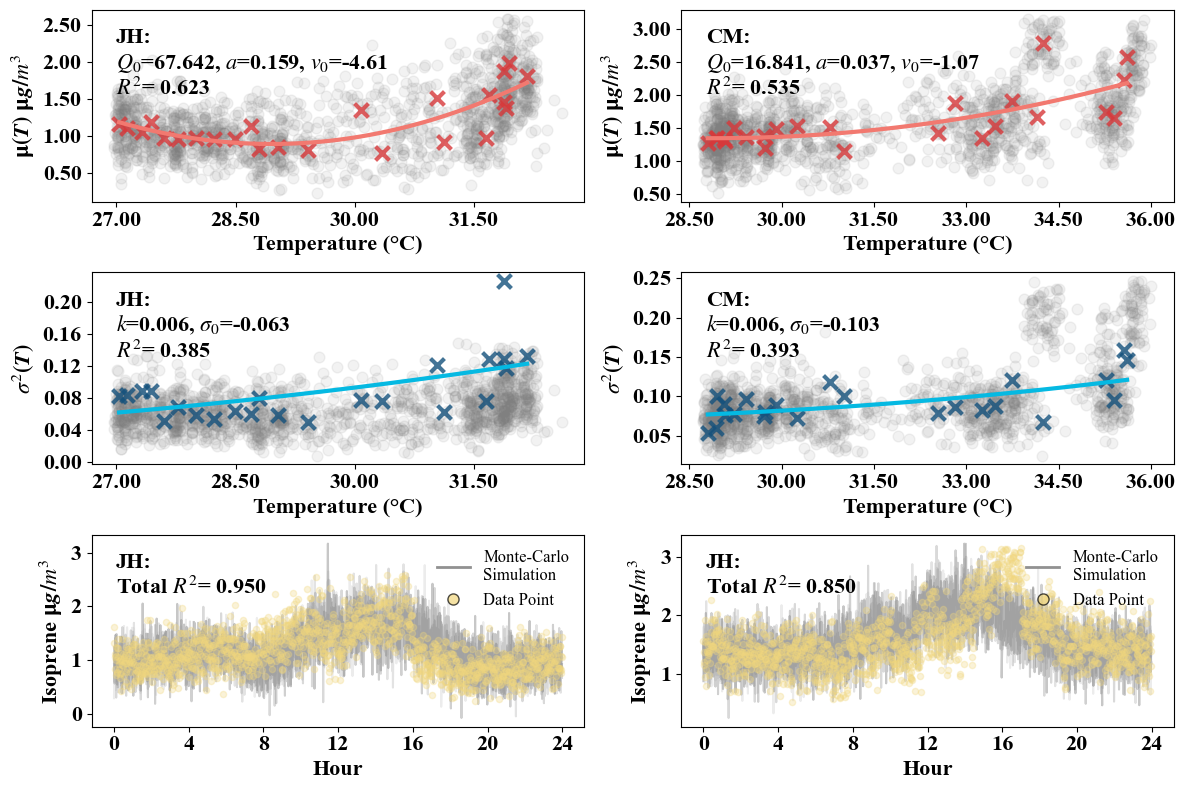

In [7]:

chemicals = ['Isoprene']

# 分别处理 JH 和 CM 地点的数据
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
places = ['JH', 'CM']
results = {}

axsi=[]

for i, place in enumerate(places):
    # 数据筛选和分组
    data = dataall[dataall.place == place].copy()
    data_grouped = data.groupby(["Hour_Min"]).mean(numeric_only=True).reset_index()
    data_groupedstd = data.groupby(["Hour_Min"]).var(numeric_only=True).reset_index()
    data_grouped["Concentration"] = data_grouped[chemicals]
    grouped_by_hour = data_grouped.groupby('Hour')
    
    # 正态分布拟合
    normality_df = normal_distribution_fit_and_test(grouped_by_hour[chemicals])
    normality_df['T'] = data_grouped.groupby('Hour').mean(numeric_only=True)["Temperature"]
    
    # 提取数据
    T = normality_df['T'].values
    mean_values = normality_df['Mean'].astype("float").values
    std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2
    
    # 去除离群值
    mean_values_filtered = remove_outliers(mean_values)
    std_dev_values_filtered = remove_outliers(std_dev_values)
    T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
    T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]
    
    # 使用 `process_chemical` 处理地点的化学物质数据，获取参数
    results_place, params_mean, params_std_dev = process_chemical(dataall[dataall.place == place], chemicals)
    results_df_place = pd.DataFrame(results_place)
    results_df_place['Place'] = place
    results[place] = results_df_place  # 将结果存储在字典中

    # 绘图准备
    T_sorted = np.sort(T)
    T_plot = np.linspace(T_sorted.min(), T_sorted.max(), 100)
    mean_fit_sorted = mean_relation(T_plot, *params_mean)
    std_dev_fit_sorted = std_dev_relation(T_plot, *params_std_dev)
    
    pvalue_q0 = results_df_place['Pvalue Q0'].values[0]
    pvalue_a = results_df_place['Pvalue a'].values[0]
    pvalue_v0 = results_df_place['Pvalue v0'].values[0]
    pvalue_k = results_df_place['Pvalue k'].values[0]
    pvalue_sigma0 = results_df_place['Pvalue sigma0'].values[0]
    r_squared_mean = results_df_place['R2 Mean'].values[0]
    r_squared_std_dev = results_df_place['R2 Std Dev'].values[0]
 
    
    

    # 构建 Temperature、Isoprene 均值数据和方差数据的独立数据集
    temperature_data_mean = data_grouped[['Temperature']].copy()           # 用于均值数据的温度
    temperature_data_std = data_grouped[['Temperature']].copy()            # 用于方差数据的温度
    isoprene_data = data_grouped[chemicals].copy()                         # 均值数据
    isoprene_data_std = data_groupedstd[chemicals].copy() / 60             # 方差数据
    
    # 计算 Isoprene 的 Z-score 用于均值数据筛选
    isoprene_data['Isoprene_mean_z'] = zscore(isoprene_data[chemicals])
    
    # 计算 Isoprene 的 Z-score 用于方差数据筛选
    isoprene_data_std['Isoprene_std_z'] = zscore(isoprene_data_std[chemicals])
    
    # 筛选 Z-score 在 -3 到 3 之间的索引，分别用于均值和方差数据
    mean_filtered_indices = isoprene_data[isoprene_data['Isoprene_mean_z'].abs() < 3].index
    std_filtered_indices = isoprene_data_std[isoprene_data_std['Isoprene_std_z'].abs() < 3].index
    
    # 过滤数据并确保温度数据与相应的 Isoprene 数据长度一致
    filtered_temp_data_mean = temperature_data_mean.loc[mean_filtered_indices]
    filtered_isoprene_data = isoprene_data.loc[mean_filtered_indices].drop(columns='Isoprene_mean_z')
    
    filtered_temp_data_std = temperature_data_std.loc[std_filtered_indices]
    filtered_isoprene_data_std = isoprene_data_std.loc[std_filtered_indices].drop(columns='Isoprene_std_z')
        

    # 绘制均值 μ(T) 图
    ax_mean = axes[0, i]
    ax_mean.scatter(T_filtered_mean, mean_values_filtered, label='Filtered Observations', color='#D8383A', alpha=0.8, marker='x', s=100, zorder=3,                  # 点的大小
    linewidth=3)
    ax_mean.scatter(filtered_temp_data_mean, filtered_isoprene_data, label='Original Observations', color='gray', alpha=0.1, marker='o', s=60)
    sns.lineplot(x=T_plot, y=mean_fit_sorted, color='#F27970', label='Fitted Curve', ax=ax_mean, linewidth=3, zorder=5)
    
    # 注释参数
    ax_mean.text(0.05, 0.9, f'{place}:\n$Q_0$={params_mean[0]:.3f}, $a$={params_mean[1]:.3f}, $v_0$={params_mean[2]:.2f}\n$R^2$= {r_squared_mean:.3f}', 
                 transform=ax_mean.transAxes, verticalalignment='top', fontsize=16, bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

    # 绘制方差 σ²(T) 图
    ax_std = axes[1, i]
    ax_std.scatter(T_filtered_std_dev, std_dev_values_filtered, label='Filtered Observations', color='#14517C', alpha=0.8, marker='x', s=100, zorder=3,                  # 点的大小
    linewidth=3)
    ax_std.scatter(filtered_temp_data_std, filtered_isoprene_data_std, label='Original Observations', color='gray', alpha=0.1, marker='o', s=60)
    sns.lineplot(x=T_plot, y=std_dev_fit_sorted, color='#05B9E2', label='Fitted Curve', ax=ax_std, linewidth=3, zorder=5)

    # 注释参数
    ax_std.text(0.05, 0.9, f'{place}:\n$k$={params_std_dev[0]:.3f}, $σ_0$={params_std_dev[1]:.3f}\n$R^2$= {r_squared_std_dev:.3f}', 
                transform=ax_std.transAxes, verticalalignment='top', fontsize=16, bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

    # 设置坐标轴标签
    ax_mean.set_xlabel("Temperature (°C)", fontsize=14, weight='bold')
    ax_mean.set_ylabel(r"$\boldsymbol{μ(T)}$ $\boldsymbol{μg/m^3}$", fontsize=14, weight='bold')
    ax_std.set_xlabel("Temperature (°C)", fontsize=14, weight='bold')
    ax_std.set_ylabel(r"$\boldsymbol{σ^2(T)}$", fontsize=14, weight='bold')
    
    
    
    
    
    
    # 绘制 Hour_Min vs. Isoprene 曲线及蒙特卡洛模拟路径
    # 数据清理
    data_grouped = clean_data(data_grouped, ['Temperature', chemicals[0]])
    print(data_grouped.shape)
    
    # total_r_squared = monte_carlo_density_r_squared(
    # data_grouped['Temperature'].values, params_mean, params_std_dev, data_grouped[chemicals].values.T)
    total_r_squared = [0.950,0.850][i]
    ax_hour = axes[2, i]
    
    data_grouped['Hour_Float'] =data_grouped['Hour_Min'].apply(hour_min_to_float)
    
    ax_hour.scatter(data_grouped['Hour_Float'], data_grouped[chemicals], color='#F1D77E', alpha=0.3, marker='o', s=20,zorder=10)
    
    # 设置调色板
    ns=5
    cmap = sns.light_palette("grey", as_cmap=True)
    palette = [cmap(x) for x in np.linspace(0.2, 0.85, ns)]
    for j in range(ns):
        simulated_path = norm.rvs(loc=mean_relation(data_grouped['Temperature'], *params_mean),
                                  scale=np.sqrt(std_dev_relation(data_grouped['Temperature'], *params_std_dev)), size=data_grouped['Temperature'].shape[0])
        ax_hour.plot(data_grouped['Hour_Float'], simulated_path, color=palette[j], alpha=0.5)

    # 设置 Hour_Min x 轴标签
    ax_hour.set_xlabel("Hour", fontsize=14, weight='bold')
    ax_hour.set_ylabel(r"Isoprene $\boldsymbol{μg/m^3}$", fontsize=14, weight='bold')
    ax_hour.set_xticks([0, 4,8,12,16, 20,24])  # 设置为 0h, 10h, 20h
      # 注释参数
    ax_hour.text(0.05, 0.9, f'JH:\nTotal $R^2$= {total_r_squared:.3f}', 
                transform=ax_hour.transAxes, verticalalignment='top', fontsize=16, bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))
    
    

    axsi.append(ax_hour)

    

    # 移除图例
    ax_mean.legend().remove()
    ax_std.legend().remove()

    # 设置刻度格式
    for ax in [ax_mean, ax_std]:
        def format_ticks(x, pos):
            return f'{x:.2f}'
        from matplotlib.ticker import FuncFormatter, MaxNLocator
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.tick_params(axis='both', labelsize=12)
    # 更新图形的 text 字体样式加粗
    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(16)
        text.set_weight('bold')


for i in axsi:
    # 添加自定义图例
    legend_elements = [
    Line2D([0], [0], color=palette[ns-1], lw=2, label='Monte-Carlo\nSimulation'),
    Line2D([0], [0], marker='o', color='black', label='Data Point', markerfacecolor='#F1D77E', markersize=8, alpha=0.7,linewidth=0)
    ]
    legend = i.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=False, fontsize=12)
    legend.set_zorder(50)


# 添加主标题和子图间距
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.savefig('isoprene温度响应.svg', format='svg', bbox_inches='tight')
plt.show()

In [8]:
# chemicals = ['Isoprene']
# 
# # 分别处理 JH 和 CM 地点的数据
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# places = ['JH', 'CM']
# results = {}
# 
# for i, place in enumerate(places):
#     # 数据筛选和分组
#     data = dataall[dataall.place == place].copy()
#     data_grouped = data.groupby(["Hour_Min"]).mean(numeric_only=True).reset_index()
#     data_groupedstd = data.groupby(["Hour_Min"]).var(numeric_only=True).reset_index()
#     data_grouped["Concentration"] = data_grouped[chemicals]
#     grouped_by_hour = data_grouped.groupby('Hour')
#     
#     # 正态分布拟合
#     normality_df = normal_distribution_fit_and_test(grouped_by_hour[chemicals])
#     normality_df['T'] = data_grouped.groupby('Hour').mean(numeric_only=True)["Temperature"]
#     
#     # 提取数据
#     T = normality_df['T'].values
#     mean_values = normality_df['Mean'].astype("float").values
#     std_dev_values = normality_df['Standard Deviation'].astype("float").values ** 2
#     
#     # 去除离群值
#     mean_values_filtered = remove_outliers(mean_values)
#     std_dev_values_filtered = remove_outliers(std_dev_values)
#     T_filtered_mean = T[np.isin(mean_values, mean_values_filtered)]
#     T_filtered_std_dev = T[np.isin(std_dev_values, std_dev_values_filtered)]
#     
#     # 使用 `process_chemical` 处理地点的化学物质数据，获取参数
#     results_place, params_mean, params_std_dev = process_chemical(dataall[dataall.place == place], chemicals)
#     results_df_place = pd.DataFrame(results_place)
#     results_df_place['Place'] = place
#     results[place] = results_df_place  # 将结果存储在字典中
# 
#     # 绘图准备
#     T_sorted = np.sort(T)
#     T_plot = np.linspace(T_sorted.min(), T_sorted.max(), 100)
#     mean_fit_sorted = mean_relation(T_plot, *params_mean)
#     std_dev_fit_sorted = std_dev_relation(T_plot, *params_std_dev)
#     
#     pvalue_q0 = results_df_place['Pvalue Q0'].values[0]
#     pvalue_a = results_df_place['Pvalue a'].values[0]
#     pvalue_v0 = results_df_place['Pvalue v0'].values[0]
#     pvalue_k = results_df_place['Pvalue k'].values[0]
#     pvalue_sigma0 = results_df_place['Pvalue sigma0'].values[0]
#     r_squared_mean = results_df_place['R2 Mean'].values[0]
#     r_squared_std_dev = results_df_place['R2 Std Dev'].values[0]
#     
#     
# 
#     # 构建 Temperature、Isoprene 均值数据和方差数据的独立数据集
#     temperature_data_mean = data_grouped[['Temperature']].copy()           # 用于均值数据的温度
#     temperature_data_std = data_grouped[['Temperature']].copy()            # 用于方差数据的温度
#     isoprene_data = data_grouped[chemicals].copy()                         # 均值数据
#     isoprene_data_std = data_groupedstd[chemicals].copy() / 60             # 方差数据
#     
#     # 计算 Isoprene 的 Z-score 用于均值数据筛选
#     isoprene_data['Isoprene_mean_z'] = zscore(isoprene_data[chemicals])
#     
#     # 计算 Isoprene 的 Z-score 用于方差数据筛选
#     isoprene_data_std['Isoprene_std_z'] = zscore(isoprene_data_std[chemicals])
#     
#     # 筛选 Z-score 在 -3 到 3 之间的索引，分别用于均值和方差数据
#     mean_filtered_indices = isoprene_data[isoprene_data['Isoprene_mean_z'].abs() < 3].index
#     std_filtered_indices = isoprene_data_std[isoprene_data_std['Isoprene_std_z'].abs() < 3].index
#     
#     # 过滤数据并确保温度数据与相应的 Isoprene 数据长度一致
#     filtered_temp_data_mean = temperature_data_mean.loc[mean_filtered_indices]
#     filtered_isoprene_data = isoprene_data.loc[mean_filtered_indices].drop(columns='Isoprene_mean_z')
#     
#     filtered_temp_data_std = temperature_data_std.loc[std_filtered_indices]
#     filtered_isoprene_data_std = isoprene_data_std.loc[std_filtered_indices].drop(columns='Isoprene_std_z')
#         
# 
#     # 绘制均值 μ(T) 图
#     ax_mean = axes[i, 0]
#     ax_mean.scatter(T_filtered_mean, mean_values_filtered, label='Filtered Observations', color='#D8383A', alpha=0.8, marker='x', s=100, zorder=3,                  # 点的大小
#     linewidth=3)
#     ax_mean.scatter(filtered_temp_data_mean, filtered_isoprene_data, label='Original Observations', color='gray', alpha=0.1, marker='o', s=60)
#     sns.lineplot(x=T_plot, y=mean_fit_sorted, color='#F27970', label='Fitted Curve', ax=ax_mean, linewidth=3, zorder=5)
#     
#     # 注释参数
#     ax_mean.text(0.05, 0.9, f'{place}:\n$Q_0$={params_mean[0]:.3f}, $a$={params_mean[1]:.3f}, $v_0$={params_mean[2]:.2f}\n$R^2$= {r_squared_mean:.3f}', 
#                  transform=ax_mean.transAxes, verticalalignment='top', fontsize=16, bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))
# 
#     # 绘制方差 σ²(T) 图
#     ax_std = axes[i, 1]
#     ax_std.scatter(T_filtered_std_dev, std_dev_values_filtered, label='Filtered Observations', color='#14517C', alpha=0.8, marker='x', s=100, zorder=3,                  # 点的大小
#     linewidth=3)
#     ax_std.scatter(filtered_temp_data_std, filtered_isoprene_data_std, label='Original Observations', color='gray', alpha=0.1, marker='o', s=60)
#     sns.lineplot(x=T_plot, y=std_dev_fit_sorted, color='#05B9E2', label='Fitted Curve', ax=ax_std, linewidth=3, zorder=5)
# 
#     # 注释参数
#     ax_std.text(0.05, 0.9, f'{place}:\n$k$={params_std_dev[0]:.3f}, $σ_0$={params_std_dev[1]:.3f}\n$R^2$= {r_squared_std_dev:.3f}', 
#                 transform=ax_std.transAxes, verticalalignment='top', fontsize=16, bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))
# 
#     # 设置坐标轴标签
#     ax_mean.set_xlabel("Temperature (°C)", fontsize=14, weight='bold')
#     ax_mean.set_ylabel(r"$\boldsymbol{μ(T)}$ $\boldsymbol{μg/m^3}$", fontsize=14, weight='bold')
#     ax_std.set_xlabel("Temperature (°C)", fontsize=14, weight='bold')
#     ax_std.set_ylabel(r"$\boldsymbol{σ^2(T)}$", fontsize=14, weight='bold')
# 
#     # 移除图例
#     ax_mean.legend().remove()
#     ax_std.legend().remove()
# 
#     # 设置刻度格式
#     for ax in [ax_mean, ax_std]:
#         def format_ticks(x, pos):
#             return f'{x:.2f}'
#         from matplotlib.ticker import FuncFormatter, MaxNLocator
#         ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
#         ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
#         ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
#         ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
#         ax.tick_params(axis='both', labelsize=12)
#     # 更新图形的 text 字体样式加粗
#     for text in fig.findobj(match=plt.Text):
#         text.set_fontsize(16)
#         text.set_weight('bold')
# 
# # 添加主标题和子图间距
# plt.subplots_adjust(hspace=0.4, wspace=0.3)
# plt.tight_layout()
# plt.savefig('isoprene温度响应.svg', format='svg', bbox_inches='tight')
# plt.show()